In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import acf as acf_func

plt.style.use("ggplot")
import arch
import yfinance as yf
import datetime as dt
import pmdarima as pm
from pmdarima import model_selection
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.stattools as stattools
import statsmodels.api as sm

ModuleNotFoundError: No module named 'frozendict'

Cointegration means if two series are unstationary, but a linear combination (usually a difference) of them can be a stationary series. A more formal definition below.

If $\{x_t\}$ and $\{y_t\}$ are two non-stationary time series, if the linear combination of them, i.e. $ax_t+by_t$ is stationary, then we say $\{x_t\}$ and $\{y_t\}$ are cointegrated.

Here is an example, both generated series are unstationary, with the same slope but different constant terms.

The common test is **Augmented Engle-Granger test**, with hypotheses
$$
H_0: \text{No cointegration}\\
H_1: \text{Cointegration presents}
$$

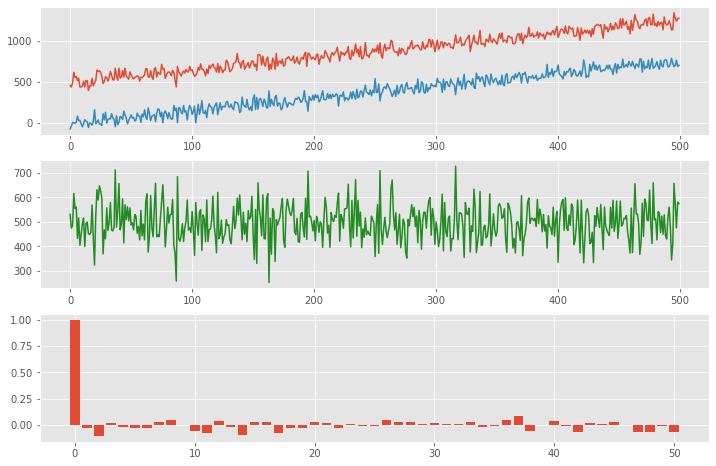

p-value of Augmented Engle-Granger test:8.022197678401672e-29


In [2]:
n_samples = 500
x = np.arange(n_samples)
y1 = 500 + 1.5 * x + np.random.normal(0, 50, size=n_samples)
y2 = 5 + 1.5 * x + np.random.normal(0, 50, size=n_samples)

y1_m_y2_acf = acf_func(y1 - y2, nlags=50)
fig, ax = plt.subplots(figsize=(12, 8), nrows=3, ncols=1)
ax[0].plot(y1)
ax[0].plot(y2)
ax[1].plot(y1 - y2, color="ForestGreen")
ax[2].bar(np.arange(len(y1_m_y2_acf)), y1_m_y2_acf)
plt.show()

result = stattools.coint(y1, y2)
print("p-value of Augmented Engle-Granger test:{}".format(result[1]))

The difference between two series, i.e.$[1, -1]$, is a most common linear combination we use in cointegration, and of course the test result shows predominant evidence to support cointegration because the models are designed to be so.

Why cointegration is useful for trading? Because it's one of mathematical foundation of mean reverting strategies, and we can construct a 'synthetic' stationary series with a combination of any arbitrary amount of instruments. 

In [3]:
df = yf.download(
    ["USO", "XOM"],
    start="2019-01-01",
    end="2020-01-01",
    progress=True,
    actions="inline",
    interval="1d",
)

[*********************100%***********************]  2 of 2 completed


In [4]:
df = df["Adj Close"]
df.columns = ["USO", "XOM"]

<AxesSubplot:xlabel='Date'>

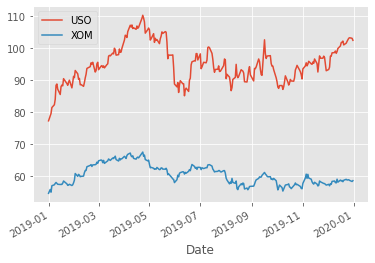

In [5]:
df.plot()

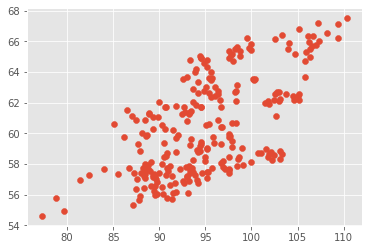

In [6]:
plt.scatter(df["USO"], df["XOM"])

Linear regression between two indices
$$
y_t =\beta_1 + \beta_2 x_t + \varepsilon_t
$$

In [7]:
X = df["XOM"]
X = sm.add_constant(df["XOM"])  # adding a constant
Y = df["USO"]
results = sm.OLS(Y, X).fit()

This is residual plot
$$
\hat{\varepsilon_t} = \hat{y}_t - \beta_1 - \beta_2 x_t
$$

<AxesSubplot:xlabel='Date'>

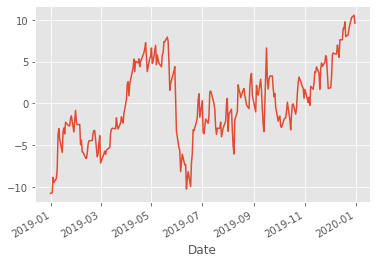

In [8]:
results.resid.plot()

Cointegrated Augmented Dickey-Fuller (CADF) could be useful here. It determines the optimal hedge ratio by performing a linear regression against the two time series.

In [9]:
results.params

const    21.617455
XOM       1.216887
dtype: float64

In [10]:
cadf = stattools.adfuller(results.resid)

In [11]:
print("ADF Statistic: %f" % cadf[0])
print("p-value: %f" % cadf[1])

ADF Statistic: -2.843330
p-value: 0.052346


The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root.